In [1]:
import eventDrivenSimulation as eds
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import show as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [2]:
CONFIG = {}

CONFIG['LAT'] = 51.34053598409240
CONFIG['LON'] = 12.381419774766130
CONFIG['RADIUS'] = 500
CONFIG['NUM_UES'] = 400
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [21]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.05, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

In [36]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']
        
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#ea0a8e'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)


display(ul_scenario_map)

In [88]:
df_ue=pd.DataFrame(ue_data)

In [89]:
df_cell = pd.DataFrame(cell_data)

In [90]:
sectors=df_cell['pci'].unique()

In [91]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [92]:
user_dataframe=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
user_dataframe = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [93]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [94]:
df=user_dataframe.copy()
SINR_list=np.array([])
SINRwithCoMP_list=np.array([])
SINRwithCoMP_phaseshiftList=np.array([])
tp_1_list=np.array([])
tp_2_list=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:][2:] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    SINR= P[0]/(np.sum(P[1:])+noise)
    SINRwithCoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:])+noise)
    #phi=random.gauss(0, math.pi)
    phi=random.gauss(0, math.pi/4)
    SINRwithCoMP_phaseshift=10*np.log10((np.power(A[0]+A[1]*np.cos(phi),2)+np.power(A[1]*np.sin(phi),2))/(np.sum(P[2:])+noise))
    
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINRwithCoMP_list=np.append(SINRwithCoMP_list,10*np.log10(SINRwithCoMP))
    SINRwithCoMP_phaseshiftList=np.append(SINRwithCoMP_phaseshiftList,SINRwithCoMP_phaseshift)

    tp_1_list=np.append(tp_1_list,index[0])
    tp_2_list=np.append(tp_2_list,index[1])

##### Building the dataframe

In [95]:
df['lat']=user_dataframe['lat']
df['lon']=user_dataframe['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINRwithCoMP_list
df['SINR-CoMP with phaseshift [dB]']=SINRwithCoMP_phaseshiftList
df['TP1']=tp_1_list.astype(int)
df['TP2']=tp_2_list.astype(int)
df['qos']=np.zeros(len(user_dataframe)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(user_dataframe))

#### Define general parameters for the simulation

In [96]:
max_prb=50 #number of prbs defined by the system bandwidth
ue_nr=15 #number of ues per pci
metric=[1,1] #defines the exponents of the metric (standard metric is pf ->[1,1])

#### Sort out PCIs that have less than ue_nr users -> edge of the Scenario

In [97]:
np.unique(df['TP1'])

array([132, 133, 134, 251, 318, 319, 320, 631, 774, 775, 776, 901])

In [98]:
#check if the number of users (positions) for the serving pci is >10
df_filter=df.groupby('TP1')
count=0
for i in df['TP1'].unique():
    k=df_filter.get_group(i)
    if(len(k)<ue_nr):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['TP1']!=i]
    count+=1

In [99]:
df

,lat,lon,168,169,170,757,758,756,105,107,...,531,533,532,SINR [dB],SINR-CoMP [dB],SINR-CoMP with phaseshift [dB],TP1,TP2,qos,id
0,51.341599,12.382275,-142,-142,-113,-140,-150,-124,-118,-118,...,-144,-148,-120,-3.454491,4.008871,2.397163,133,775,0.0,0
1,51.340462,12.380442,-136,-140,-111,-135,-149,-124,-123,-120,...,-142,-149,-122,-1.075300,11.534408,11.274610,775,133,0.0,1
2,51.337441,12.384419,-130,-145,-121,-135,-152,-131,-134,-114,...,-131,-147,-123,7.160564,14.416453,14.302472,776,251,0.0,2
3,51.342215,12.378895,-139,-139,-109,-138,-147,-121,-118,-126,...,-148,-151,-122,7.733841,14.029321,13.999214,133,320,0.0,3
4,51.336628,12.378696,-119,-139,-119,-128,-149,-131,-134,-121,...,-136,-151,-128,-4.122258,3.008212,1.041362,319,776,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,51.342257,12.384934,-145,-145,-116,-143,-152,-125,-113,-113,...,-145,-146,-117,-3.456749,5.169348,5.163237,774,134,0.0,394
396,51.338848,12.386195,-136,-146,-120,-138,-153,-129,-131,-110,...,-132,-145,-119,1.392027,9.094618,8.386915,774,776,0.0,396
397,51.341246,12.381394,-141,-141,-112,-138,-149,-124,-120,-119,...,-144,-149,-121,1.441480,9.204925,7.401408,133,775,0.0,397
398,51.340746,12.377158,-134,-135,-106,-132,-146,-121,-123,-126,...,-145,-152,-124,21.922224,25.341285,25.339001,319,133,0.0,398


#### Define a cluster

In [100]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [133 775 776 319 318 134 774 132]


In [101]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

if following code says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [102]:
index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packet that arrives from a user [Bit]
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

# select only ue_nr of users from given index 
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

## Analysis for mu = 4ms (av. packet arrival time)

Evaluation: timer=2000 s
8 sectors in one cluster -> T=26s
2 sectors in one cluster -> T=6s

In [103]:
#r='random' 
r='deterministic'

mu=4
env=simpy.Environment()
sched_l=[]
sched3=eds.sched_inst(env)
for i in cluster:
    sched1=eds.sched_inst(env)
    sched_l.append(eds.sched_inst(env))

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
        counter+=1    
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

env=simpy.Environment()

SCHEDULE_T=2 #Clock of scheduler -> every 2ms

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_per_pci[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,mu))
    

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_per_pci[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshif'))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    prb_number_normal=max_prb-prb_number_comp[i]
    env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=2000
env.run(until=timer)

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


### Graph Visualization
Choose between two modes -> comp-gain shows a color plot for the gain with comp & user-assignment shows which users are assigned to which pci

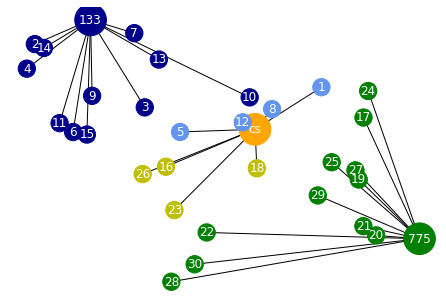

In [104]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
BS_pos={}
for i in cluster:
    BS_pos.update({i: bs_dict[i]})

G=nx.Graph()

x=np.arange(1,ue_nr*len(cluster))
G.add_node('cs')
for i in cluster:
    G.add_node(str(i))

BS_pos={}
for i in cluster:
    BS_pos.update({i: bs_dict[i]})

loc_list=np.array(list(BS_pos.values()))
loc_dic={}
loc_dic['cs']=[loc_list[:,0].mean(),loc_list[:,1].mean()]

for i in cluster:
    loc_dic[str(i)]=BS_pos[i]

G.add_nodes_from(x)

#n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
       # if(i.cell1==cluster[0]):
        #    n_c=np.append(n_c,'cornflowerblue')
        #elif(i.cell1==cluster[1]):
         #   n_c=np.append(n_c,'y')
    else:
        for j in cluster:
            if(i.cell1==j):
                G.add_edge(counter,str(j))
    counter+=1

n_c=np.array(['orange'])
color_selection_bs=['darkblue','green','purple','black','darkred']
color_selection_user=['cornflowerblue','y','plum','gray','red']
if(len(cluster) > len(color_selection_bs)):
    color_selection_bs=[]
    color_selection_user=[]
    for i in cluster:
        color_selection_bs.append('darkblue')
        color_selection_user.append('cornflowerblue')
n_c=np.append(n_c,color_selection_bs[0:len(cluster)])
color_edge_ues = dict(zip(cluster,color_selection_user[0:len(cluster)]))    
color_bs=dict(zip(cluster,color_selection_bs[0:len(cluster)]))  
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        for j in cluster:
            if(i.cell1==j):
                n_c=np.append(n_c,color_edge_ues[j])        
    else:
        for j in cluster:
            if(i.cell1==j):
                G.add_edge(counter,str(j))
                n_c=np.append(n_c,color_bs[j])
    counter+=1
        
n_s=np.ones(ue_nr*len(cluster)+1+len(cluster))*300
n_s[0:(1+len(cluster))]=1000

m=np.array([])
m=np.append(m,np.ones(len(cluster)+1))
t=np.array([])
t=np.append(t,np.ones(len(cluster)+1))
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs_comp)
    else:
        t=np.append(t,i.tbs)
m[len(cluster):]=10*np.log10(m[len(cluster):])
vmin = np.min(m)
vmax = np.max(m)
m[0:len(cluster)]=np.mean(m[len(cluster):])

if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)

plt.draw()
plt.show()

## Numerical Results

In [105]:
df_res=eds.ue_to_df(ue_all)
df1=df_res[df_res['TP1']==cluster[0]]
df2=df_res[df_res['TP1']==cluster[1]]

for i in cluster:
    df3=df_res[df_res['TP1']==i]
    print('average comp gain pci '+str(i)+': '+str((df3['mR gain'].mean()-1)*100)+'%')
print('average comp gain: '+str(round(((df1['mR gain'].mean()+df2['mR gain'].mean())/2-1)*100))+'%')

average comp gain pci 133: 22.306899297618955%
average comp gain pci 775: 26.24492904035258%
average comp gain: 24%


In [106]:
#r='random' 
r='deterministic'

mu=4
env=simpy.Environment()
sched_l=[]
sched3=eds.sched_inst(env)
for i in cluster:
    sched1=eds.sched_inst(env)
    sched_l.append(eds.sched_inst(env))

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
        counter+=1    
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

env=simpy.Environment()

SCHEDULE_T=2 #Clock of scheduler -> every 2ms

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_per_pci[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,mu))
    

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_per_pci[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshift'))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    prb_number_normal=max_prb-prb_number_comp[i]
    env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=2000
env.run(until=timer)

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


In [107]:
df_res=eds.ue_to_df(ue_all)
df1=df_res[df_res['TP1']==cluster[0]]
df2=df_res[df_res['TP1']==cluster[1]]

for i in cluster:
    df3=df_res[df_res['TP1']==i]
    print('average comp gain pci '+str(i)+': '+str((df3['mR gain'].mean()-1)*100)+'%')
print('average comp gain: '+str(round(((df1['mR gain'].mean()+df2['mR gain'].mean())/2-1)*100))+'%')

average comp gain pci 133: 18.04376371842298%
average comp gain pci 775: 21.844757773279746%
average comp gain: 20%


In [108]:
comp_user=df_res[df_res['comp']==1]
df_nc=df_res[df_res['comp']==0]

all ues
10% Quantil: -22.663964619263012
90% Quantil: 147.7873628577976
50% Quantil (Median): -21.78591683861943
comp ues
10% Quantil: 47.50538864115235
90% Quantil: 213.55212234689782
50% Quantil (Median): 144.30557189701273
no_comp ues
10% Quantil: -22.90243353116646
90% Quantil: -19.317526704008745
50% Quantil (Median): -22.069194634957732


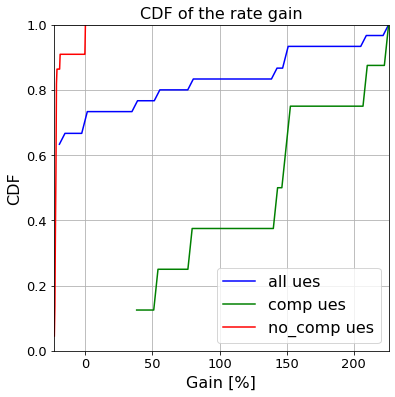

In [109]:
x=(df_res['mR gain']-1)*100
y=(comp_user['mR gain']-1)*100
z=(df_nc['mR gain']-1)*100
sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [%]',60)